### Multiclass Classification (with binary classifiers)
- OvR: _one-versus-the-rest_ (less classifier needed)
- OvO: _one-versus-one_

In [1]:
# load data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [2]:
# train SVM with default strategy
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

some_digit = X[0]
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [3]:
svm_clf.decision_function([some_digit])  # check score per class

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
# train SVM with assigned strategy
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])  # array(['5'], dtype=object)
len(ovr_clf.estimators_)       # 10

In [ ]:
# improve accuracy by scaling
from skearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(ovr_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

#### Error Analysis
- frequent errors  -> confusion matrix
- individual errors

In [ ]:
# calculate & plot confusion matrix
y_train_pred = cross_val_predict(ovr_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# focus on the errors (off-diagonal cells)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums       # absolute values -> error rate

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# ==> decide on further preprocessings, according to the errors/sensitivities

### Multilabel Classification
A classification system that outputs multiple binary tags. \
e.g.: face detection in image

In [22]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
    
y_train_large = (y_train.astype(int) >= 7)
y_train_odd = (y_train.astype(int) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]  # stack two labels together
# https://numpy.org/doc/stable/reference/generated/numpy.c_.html?highlight=c_#numpy.c_

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [23]:
knn_clf.predict([some_digit])   # if larger than 6, if odd

array([[False,  True]])

In [ ]:
# evaluate
from sklearn.model_selection import cross_val_predict

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")  # averaged f1-score across all labels
# average="weighted": when instances of each label are not balanced in amount

### Multioutput Classification
A generalized version of multilabel classification, where each label can be multiclass\
e.g.: noise removing from images

In [4]:
# add noise to pixel intensities
import numpy as np

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

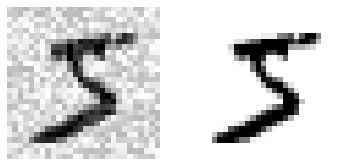

In [14]:
# show example of X_train_mod and y_train_mod
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

some_digit = X_train_mod[0]
some_digit_image_x = some_digit.reshape(28, 28)
some_digit = y_train_mod[0]
some_digit_image_y = some_digit.reshape(28, 28)

ax1.imshow(some_digit_image_x, cmap="binary")
ax1.axis("off")
ax2.imshow(some_digit_image_y, cmap="binary")
ax2.axis("off")

plt.show()

In [ ]:
# train knn to clean the noisy image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)